In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold, PredefinedSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, make_scorer
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [2]:
import sys

file_path = "https://raw.githubusercontent.com/FarzinSohraby/PathInHydro/refs/heads/main/"

data = pd.read_csv(file_path+'Df_H2ase_CO_H2.csv')
data.shape

(899, 808)

In [ ]:
# Add a 'Molecule' column to distinguish CO and H2 based on the 'Trajectory' column
data['Molecule'] = data['Trajectory'].apply(lambda x: 'H2' if 'H2' in x else 'CO')
data = data.drop(["Trajectory", "Frame","Binary"], axis=1)
X = data.drop(['Pathway-new', "Molecule"], axis=1)  # Features
y = data['Pathway-new']  # Target variable

# Perform stratified train/validation/test split based on 'Molecule' column to ensure the 75/15/15% distribution for CO and H2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=data['Molecule'])


# oversample the training set
oversampler = RandomOverSampler(random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
# Calculate distribution percentages for the entire dataset
total_distribution = data['Molecule'].value_counts(normalize=True) * 100
print("Overall Distribution (%):\n", total_distribution)

# Calculate distribution in each set
train_distribution = data.loc[X_train.index, 'Molecule'].value_counts(normalize=True) * 100
test_distribution = data.loc[X_test.index, 'Molecule'].value_counts(normalize=True) * 100

print("\nTraining Set Distribution (%):\n", train_distribution)
print("\nTest Set Distribution (%):\n", test_distribution)


Overall Distribution (%):
 CO    91.768632
H2     8.231368
Name: Molecule, dtype: float64

Training Set Distribution (%):
 CO    91.732909
H2     8.267091
Name: Molecule, dtype: float64

Test Set Distribution (%):
 CO    91.851852
H2     8.148148
Name: Molecule, dtype: float64


In [ ]:
# scoring metrics
scoring = {
    'BA': make_scorer(balanced_accuracy_score),
    'MCC': make_scorer(matthews_corrcoef)}

In [ ]:
# Define the SVM model
svm_classifier = SVC(random_state=1)

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Grid search
grid_search_svm = GridSearchCV(estimator=svm_classifier, param_grid=param_grid_svm,
                               cv=5, scoring=scoring, refit='BA', n_jobs=-1)
grid_search_svm.fit(X_train_resampled, y_train_resampled)

best_params = grid_search_svm.cv_results_['params'][np.argmin(grid_search_svm.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
log_reg_classifier = LogisticRegression(max_iter=5000, random_state=1)

param_grid_log_reg = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# Grid search
grid_search_log_reg = GridSearchCV(estimator=log_reg_classifier, param_grid=param_grid_log_reg,
                                   cv=5, n_jobs=-1, scoring=scoring, refit='BA')
grid_search_log_reg.fit(X_train_resampled, y_train_resampled)

best_params = grid_search_log_reg.cv_results_['params'][np.argmin(grid_search_log_reg.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

/home/farzin/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best parameters: {'C': 100, 'l1_ratio': 0, 'solver': 'saga'}


In [ ]:
# Define the KNN model
knn_classifier = KNeighborsClassifier()

# Set up the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Grid search
grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid_knn,
                               cv=5, scoring=scoring, refit='BA', n_jobs=-1)
grid_search_knn.fit(X_train_resampled, y_train_resampled)

best_params = grid_search_knn.cv_results_['params'][np.argmin(grid_search_knn.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1)

param_grid_rf = {
    'max_depth': [10, 12, 15, 20, 30, 50, None],
    'ccp_alpha': [0, 0.0004, 0.0005, 0.0007, 0.001],
    'max_samples': [0.7, 0.8, 0.9, 0.95]
}

# Perform GridSearchCV with the predefined scoring
grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    cv=5,
    scoring=scoring,  # Use custom scoring metric(s)
    refit='BA',
    n_jobs=-1
)

# Fit the GridSearchCV model on the training set
grid_search_rf.fit(X_train_resampled, y_train_resampled)

best_params = grid_search_rf.cv_results_['params'][np.argmin(grid_search_rf.cv_results_['rank_test_BA'])]
cv_results = grid_search_rf.cv_results_

# Output the best parameters
print("Best parameters:", best_params)
mean_test_ba = cv_results['mean_test_BA']
std_test_ba = cv_results['std_test_BA']
mean_test_mcc = cv_results['mean_test_MCC']
std_test_mcc = cv_results['std_test_MCC']

best_rf_model = grid_search_rf.best_estimator_

print("\nBest Cross-validation Balanced Accuracy (BA):")
print(f"Mean: {grid_search_rf.cv_results_['mean_test_BA'][grid_search_rf.best_index_]:.2f}, Std: {grid_search_rf.cv_results_['std_test_BA'][grid_search_rf.best_index_]:.2f}")

print("\nBest Cross-validation Matthews Correlation Coefficient (MCC):")
print(f"Mean: {grid_search_rf.cv_results_['mean_test_MCC'][grid_search_rf.best_index_]:.2f}, Std: {grid_search_rf.cv_results_['std_test_MCC'][grid_search_rf.best_index_]:.2f}")

Best parameters: {'ccp_alpha': 0, 'max_depth': 30, 'max_samples': 0.95}

Best Cross-validation Balanced Accuracy (BA):
Mean: 0.98, Std: 0.00

Best Cross-validation Matthews Correlation Coefficient (MCC):
Mean: 0.97, Std: 0.00


In [ ]:
# Define the Gradient Boosting model
gb_classifier = GradientBoostingClassifier(n_estimators=500, tol=0.0005, random_state=1)

# Set up the parameter grid for Gradient Boosting
param_grid_gb = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9]
}

# Grid search
grid_search_gb = GridSearchCV(estimator=gb_classifier, param_grid=param_grid_gb,
                              cv=5, scoring=scoring, refit='BA', n_jobs=-1)
grid_search_gb.fit(X_train_resampled, y_train_resampled)

best_params = grid_search_gb.cv_results_['params'][np.argmin(grid_search_gb.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.7}


In [ ]:
# Define the AdaBoost model
ada_classifier = AdaBoostClassifier(random_state=1)

# Set up the parameter grid for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200, 500, 1000, 2000, 3000],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0, 1.2]
}

# Grid search
grid_search_ada = GridSearchCV(estimator=ada_classifier, param_grid=param_grid_ada,
                               cv=5, scoring=scoring, refit='BA', n_jobs=-1)
grid_search_ada.fit(X_train_resampled, y_train_resampled)

best_params = grid_search_ada.cv_results_['params'][np.argmin(grid_search_ada.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.5, 'n_estimators': 2000}


In [ ]:
algorithms = ['SVM', 'Logistic Regression', 'kNN', 'Random Forest', 'Gradient Boost', 'AdaBoost']
gs_all = [grid_search_svm, grid_search_log_reg, grid_search_knn, grid_search_rf, grid_search_gb, grid_search_ada]

# Use 'np.argmin' to find the index of the best score for each GridSearchCV object
ba_all = [gs.cv_results_['mean_test_BA'][np.argmin(gs.cv_results_['rank_test_BA'])] for gs in gs_all]
mcc_all = [gs.cv_results_['mean_test_MCC'][np.argmin(gs.cv_results_['rank_test_BA'])] for gs in gs_all]

results = pd.DataFrame.from_dict({
    'algorithm': algorithms,
    'BA test set': [f'{ba:.2f}' for ba in ba_all],
    'MCC test set': [f'{mcc:.2f}' for mcc in mcc_all],
}, orient='columns')

display(results)

,algorithm,BA test set,MCC test set
0,SVM,0.95,0.95
1,Logistic Regression,0.94,0.94
2,kNN,0.93,0.92
3,Random Forest,0.98,0.97
4,Gradient Boost,0.98,0.98
5,AdaBoost,0.78,0.76


In [ ]:
# save/load the search results
import pickle

option = 'write'

if option == 'write':
    pickle_file = open(file_path+"algorithm_test_gsall_Multiclass.pkl", "wb")
    pickle.dump(gs_all, pickle_file)
else:
    pickle_file = open(file_path+"algorithm_test_gsall-Multiclass.pkl", "rb")
    [grid_search_svm, grid_search_log_reg, grid_search_knn, grid_search_rf, grid_search_gb, grid_search_ada] = pickle.load(pickle_file)
pickle_file.close()

In [ ]:
# check the details of selected search
search_results = grid_search_rf
check_metric = "BA" # "BA" or "MCC"

# retrieve the information
ba_scores = search_results.cv_results_[f'mean_test_{check_metric}']
hyperparam_combi = search_results.cv_results_['params']
# print results for each model in the search
for combi, ba in zip(hyperparam_combi, ba_scores):
    print(f"{str(combi):<65}         {ba:.3f}")

{'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.7}                     0.947
{'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.8}                     0.949
{'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.9}                     0.949
{'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.95}                    0.947
{'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.7}                     0.958
{'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.8}                     0.959
{'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.9}                     0.957
{'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.95}                    0.961
{'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.7}                     0.971
{'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.8}                     0.973
{'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.9}                     0.972
{'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.95}                    0.973
{'ccp_alpha': 0, 'max_depth': 20, 'max_s

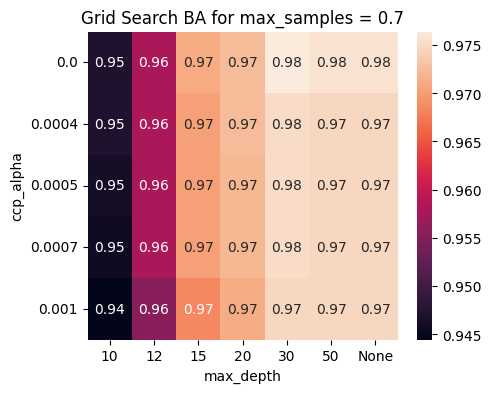

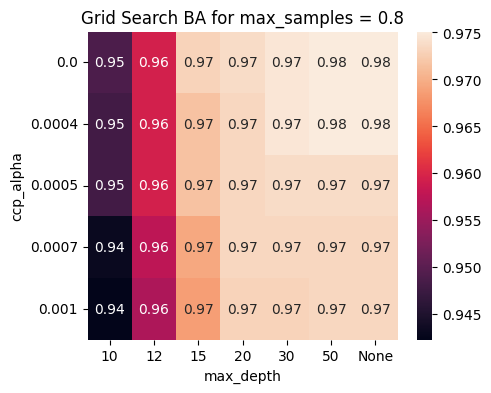

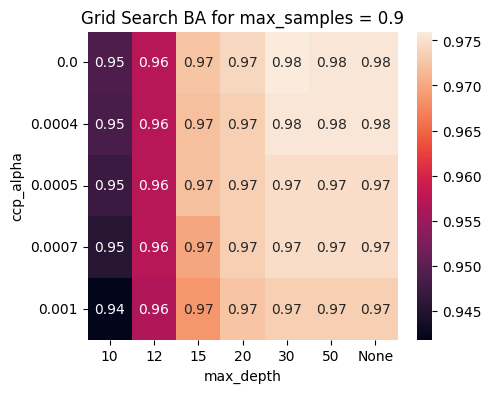

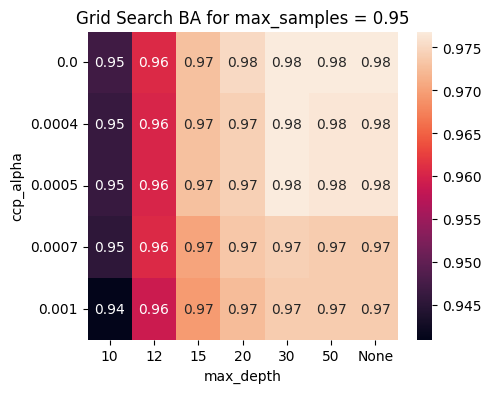

In [ ]:
param_grid = param_grid_rf
hyperparam_ax = 'max_samples'
hyperparam_x = 'max_depth'
hyperparam_y = 'ccp_alpha'

cv_scores_mat = ba_scores.reshape(len(param_grid[hyperparam_y]),
                                 len(param_grid[hyperparam_x]),
                                 len(param_grid[hyperparam_ax]))

for i in range(cv_scores_mat.shape[2]):
    cv_scores_df = pd.DataFrame(cv_scores_mat[:,:,i],
                                columns=[x if x else 'None' for x in param_grid[hyperparam_x]],
                                index=param_grid[hyperparam_y])
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    sns.heatmap(cv_scores_df, annot=True, ax=ax)
    plt.title(f'Grid Search {check_metric} for max_samples = {param_grid[hyperparam_ax][i]}')
    plt.xlabel(hyperparam_x)
    plt.ylabel(hyperparam_y)
    ax.tick_params(axis='y', rotation=0)
    plt.show()